In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

In [12]:
def emd_decompose(y_input, h_start, h_min, a):
    n = len(y_input)
    x = np.arange(n)

    h_start = max(1.0, float(h_start) * n)
    h_min   = max(1.0, float(h_min)   * n)

    residuals_list = []
    components = []
    current_residuals = y_input.copy()
    h_curr = h_start

    while h_curr >= h_min:
        n_window = int(np.ceil(h_curr))
        k_x = np.arange(-n_window, n_window + 1)
        
        weights = 0.75 * (1 - (k_x / h_curr)**2)
        weights[weights < 0] = 0
        weights = weights / weights.sum()

        numerator = fftconvolve(current_residuals, weights, mode='same')
        denominator = fftconvolve(np.ones_like(current_residuals), weights, mode='same')
        
        y_smooth = numerator / (denominator + 1e-10)
            
        components.append(y_smooth)
        current_residuals = current_residuals - y_smooth
        residuals_list.append(current_residuals.copy())
        h_curr /= a
        
    return components, residuals_list, current_residuals

In [16]:
df = pd.read_csv("Cap_10.csv", index_col=0, parse_dates=True)
df = np.log10(df)

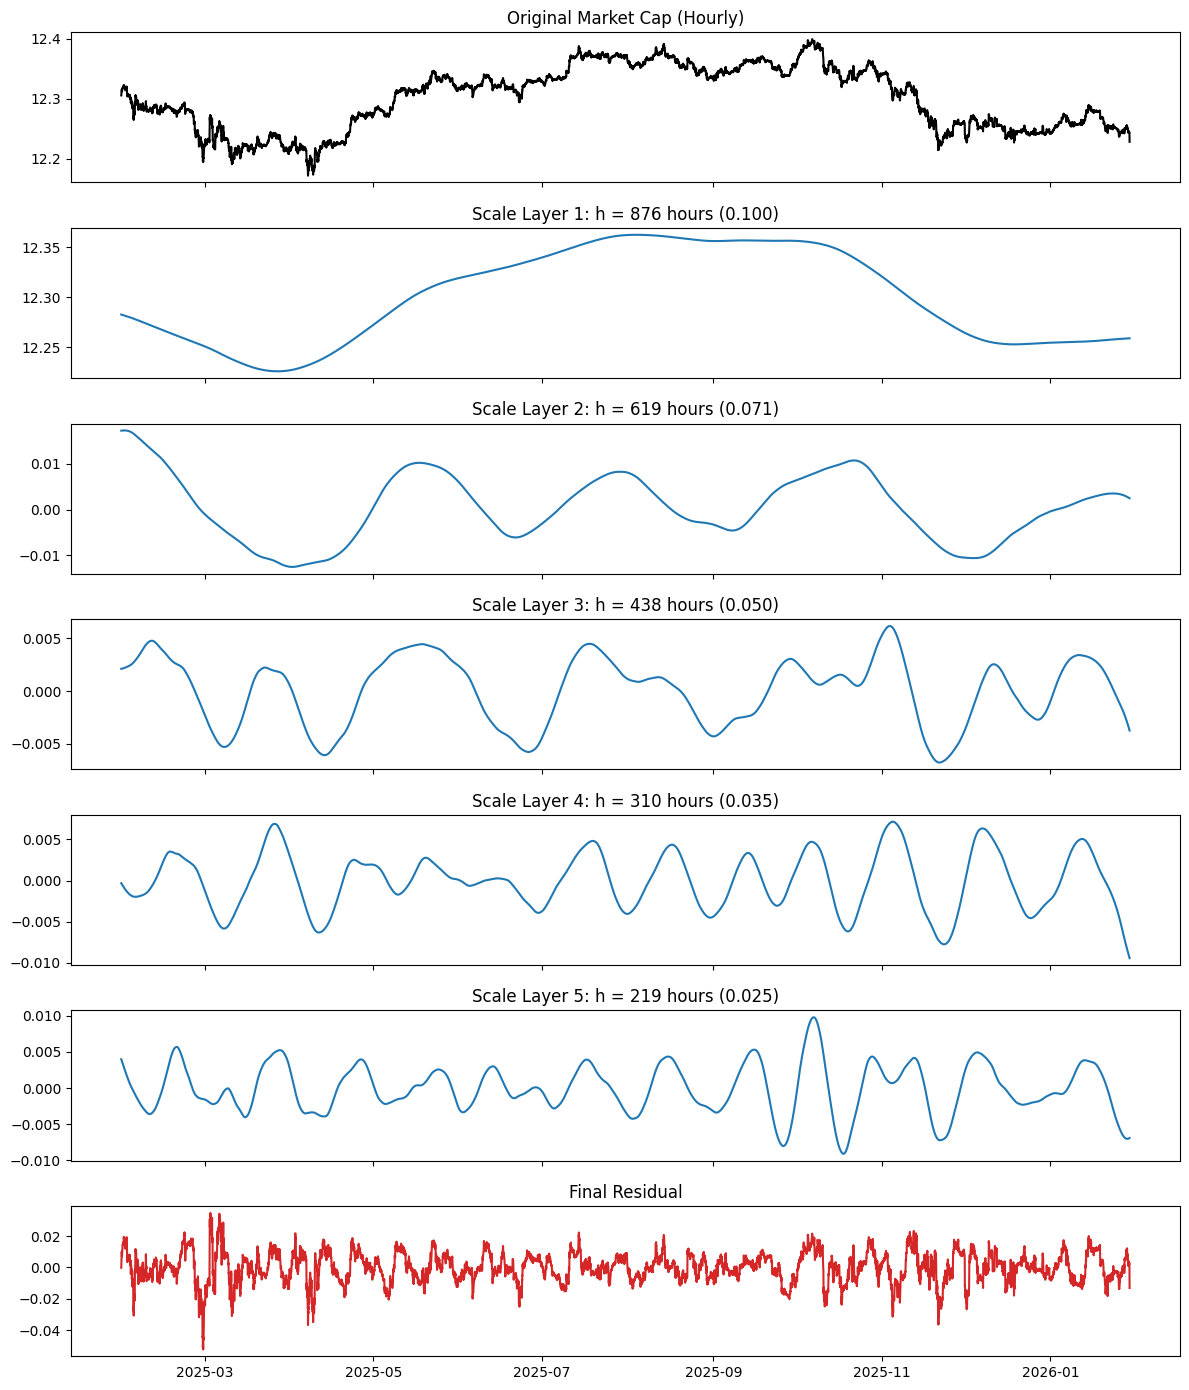

In [28]:
h_start = 0.1
h_min = 0.02
a_val = np.sqrt(2)

components, residuals_list, final_resid = emd_decompose((df.iloc[:, 0]).values, h_start, h_min, a_val)

n = len(df.iloc[:, 0].values)
n_layers = len(components)
fig, axes = plt.subplots(n_layers + 2, 1, figsize=(12, 2 * (n_layers + 2)), sharex=True)

axes[0].plot(df.index, df.iloc[:, 0], color='black')
axes[0].set_title("Original Market Cap (Hourly)")

current_h = h_start
for i in range(n_layers):
    axes[i+1].plot(df.index, components[i], color='tab:blue')
    axes[i+1].set_title(f"Scale Layer {i+1}: h = {current_h * n:.0f} hours ({current_h:.3f})")
    current_h /= a_val

axes[-1].plot(df.index, final_resid, color='tab:red')
axes[-1].set_title(f"Final Residual")

plt.tight_layout()
plt.show()